In [1]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# IEL DATA EXPLORATION - Daily Data

### Read in the data
Currently we are using data from the "Carradale Water at Dippen" Water Station. This is a water station which is located in Cambeltown, on the West Coast of Scotland. The reason for choosing this station is because it has approximately the same latitude, and geography as the fictitious island of Claddach and monitors a river pretty much all the way from the source to the river estuary. This means that the data should be representative of the data we would expect to see on Claddach.

See the README.md in the Data repository to see how this data was collected.

In [2]:
# Import the new data and create a dataframe
rain = pd.read_csv('/home/iain/Desktop/IEL/Data/Real Data/Daily Aggregates/Daily Precipitation.csv', delimiter=';')
rain.rename(columns={'Value': 'Precipitation'}, inplace=True)
flow = pd.read_csv('/home/iain/Desktop/IEL/Data/Real Data/Daily Aggregates/Daily Mean Flow Rate.csv', delimiter=';')
flow.rename(columns={'Value': 'Flow Rate'}, inplace=True)
level = pd.read_csv('/home/iain/Desktop/IEL/Data/Real Data/Daily Aggregates/Daily Mean Level.csv', delimiter=';')
level.rename(columns={'Value': 'Water Level'}, inplace=True)

# Merge the 3 datasets into one
merged = pd.merge(rain, flow, on=['#Timestamp'])
merged = pd.merge(merged, level, on=['#Timestamp'])
merged = merged.drop('Quality Code_x', axis=1)
merged = merged.drop('Quality Code_y', axis=1)
merged = merged.drop('Quality Code', axis=1)
merged.dropna(inplace=True)

### Simple Calculations

The Catchment Area of the Carradale Water at Dippen Water Station is 58.5km^2 (https://www2.sepa.org.uk/waterlevels/default.aspx?sd=t&lc=133077).
<br>1mm of rainfall is equal to 1 litre of water per square metre.

The Scottish Governments states that the estimated percentage of precipitation which runoffs into the see is approximately 73% (https://www.gov.scot/publications/scotlands-marine-atlas-information-national-marine-plan/pages/7/) However, this is extremely variable from location to location (eg. in the USA this is as low as 30% (https://www.usgs.gov/special-topics/water-science-school/science/rain-and-precipitation). As well as the fact that on a daily, or even hourly basis, this will depend upon the weather conditions as more sunshine and warmer weather will lead to more evaporation and less ending up in the river. Therefore for now, we will set the percentage of rainfall which ends up in the river to a figure which results in the cumulative water difference throughout the year being equal to 0. This will likely be changed later to a more realistic value which changes throughout the year to account for the weather conditions.

<br>hence the amount of water going into our river (measured in litres) on a given day is:
    <br><br> rainfall * 58.5 * 0.73 *1,000,000
    <br>     rainfall * 42,705,000

For the amount of water going out of the river (measured in litres) on a given day, we can use the flow data.
<br><br>We know that the flow data is measured in m^3/s, so we can convert this to litres (by multiplying by 1000) and then multiply by the number of seconds in a day (86400) to get the litres of water going out of the river on a given day.

<br>flow * 1000 * 86400
<br>flow * 86,400,000

<br>Hence the water difference on a given day is equal to:
<br><br>rainfall * 42,705,000 - flow * 86,400,000

We want to convert this back into cubic metres, so we divide by 1000
<br><br>rainfall * 42,705 - flow * 86,400

Let's add this to our dataframe and plot it.


In [3]:
waterDifference = merged['Precipitation']*40452 - merged['Flow Rate']*86400
merged['Water Difference'] = waterDifference

# Calculate the derivative of the water level for each day. Don't ask why it's calculated this way - Python was just being a pain.
levelDerivative = []
previous = merged['Water Level'][0]
flag = True
for i in merged['Water Level']:
    diff = i - previous
    if not flag:
        levelDerivative.append(diff)
    flag = False
    previous = i
levelDerivative.append(0)
merged['Level Difference'] = levelDerivative
merged.describe()

,Precipitation,Flow Rate,Water Level,Water Difference,Level Difference
count,9388.000000,9388.000000,9388.000000,9.388000e+03,9388.000000
mean,5.075852,2.571336,0.461204,-1.683508e+04,-0.000023
std,15.217056,3.502277,0.209103,5.907141e+05,0.170803
min,0.000000,0.000000,0.175000,-3.004394e+06,-1.685000
25%,0.000000,0.504000,0.306000,-1.080096e+05,-0.052000
50%,1.200000,1.251500,0.404000,-3.412800e+04,-0.010000
75%,6.800000,3.147500,0.561000,4.267620e+04,0.028000
max,949.600000,58.651000,2.532000,3.767243e+07,2.111000


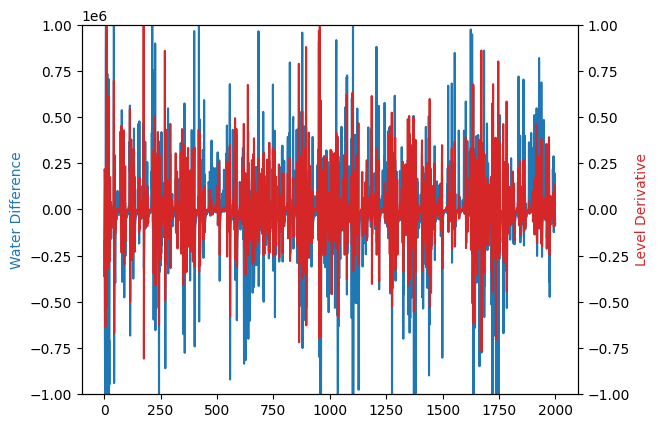

In [4]:
# Plot the water difference and the level derivative against the date with different axis scales
fig, ax1 = plt.subplots()
ax1.plot(merged['Water Difference'].iloc[0:2000])
ax1.set_ylabel('Water Difference', color='tab:blue')
ax1.set_ylim(-1000000, 1000000)
ax2 = ax1.twinx()
ax2.plot(merged['Level Difference'].iloc[0:2000], color='tab:red')
ax2.set_ylabel('Level Derivative', color='tab:red')
ax2.set_ylim(-1, 1)
plt.show()

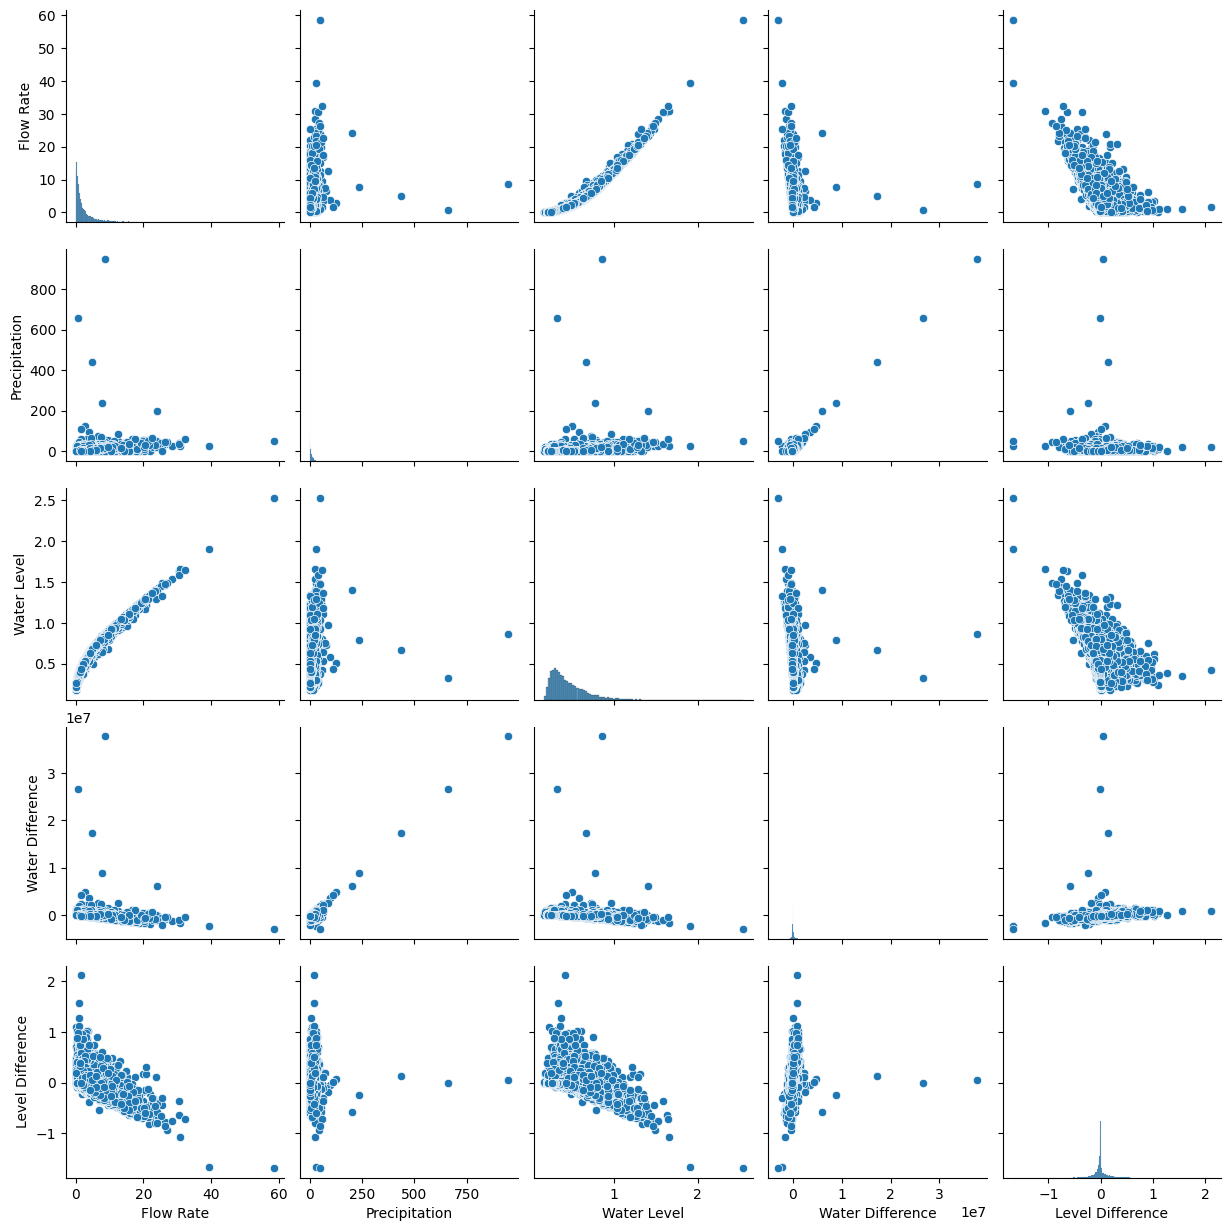

In [5]:
cols = ['Flow Rate', 'Precipitation', 'Water Level', 'Water Difference', 'Level Difference']
sns.pairplot(merged[cols], height=2.5)

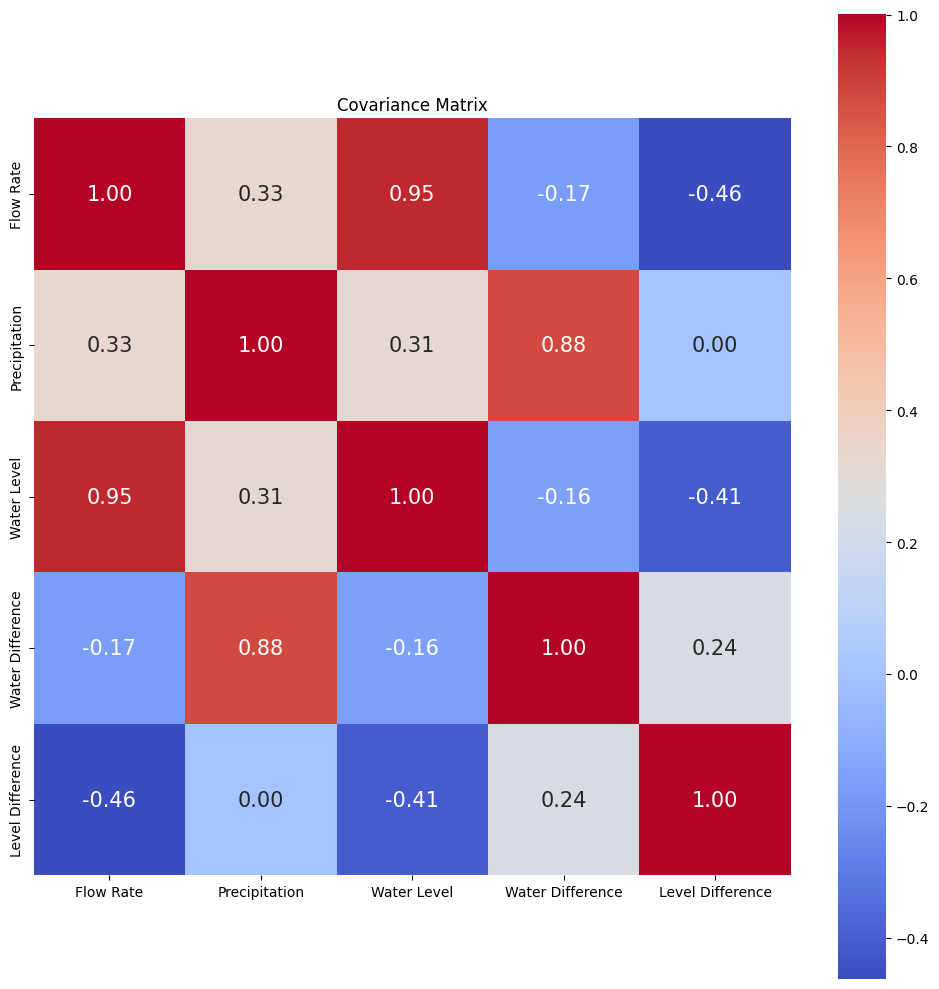

In [6]:
stdsc = StandardScaler()
X_std = stdsc.fit_transform(merged[cols].values)
cov_mat = np.cov(X_std.T)
plt.figure(figsize=(10, 10))
hm = sns.heatmap(cov_mat, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 15}, cmap='coolwarm', yticklabels=cols, xticklabels=cols)
plt.title('Covariance Matrix')
plt.tight_layout()
plt.show()

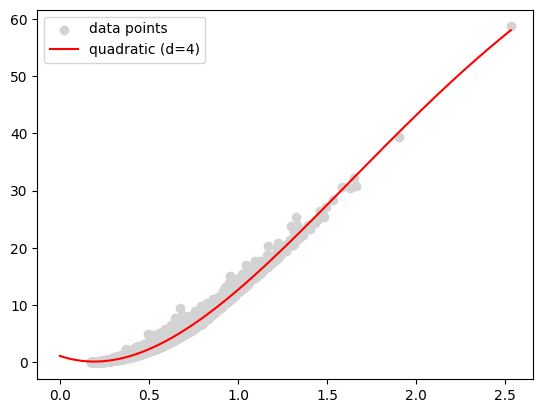

In [7]:
# Fit a polynomial curve to the data
X = merged['Water Level'].values.reshape(-1, 1)
y = merged['Flow Rate'].values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
quadratic = PolynomialFeatures(degree=4)
X_quad = quadratic.fit_transform(X)
X_quad_test = quadratic.fit_transform(X_test)
lr = LinearRegression()
lr.fit(X_quad, y)
y_quad_fit = lr.predict(X_quad)
y_quad_pred = lr.predict(X_quad_test)

# Plot the polynomial curve
plt.scatter(X, y, label='data points', color='lightgray', marker='o')

x = np.linspace(0, max(X), 1000)
y = lr.predict(quadratic.fit_transform(x.reshape(-1, 1)))
plt.plot(x, y, label='quadratic (d=4)', color='red')

plt.legend(loc='upper left')
plt.show()

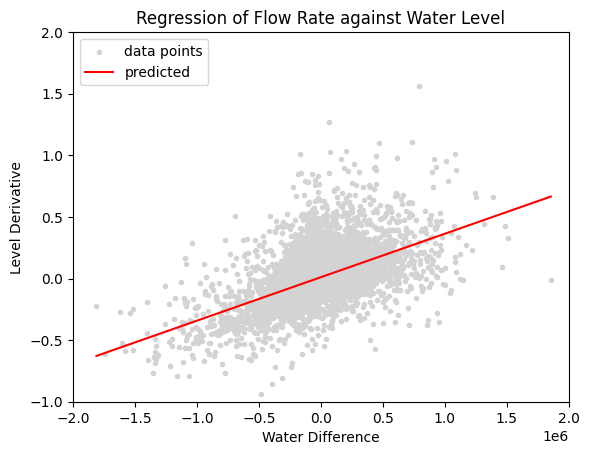

In [8]:
# Remove days with water difference > 2000000 and > 2000000
typical = merged[merged['Water Difference'] < 2000000]
typical = typical[typical['Water Difference'] > -2000000]

# Fit a polynomial curve of Water difference (independent) and level derivative (dependent)
X = typical['Water Difference'].values.reshape(-1, 1)
y = typical['Level Difference'].values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
quadratic = PolynomialFeatures(degree=1)
X_quad = quadratic.fit_transform(X)
X_quad_test = quadratic.fit_transform(X_test)
lr = LinearRegression()
lr.fit(X_quad, y)
y_quad_fit = lr.predict(X_quad)
y_quad_pred = lr.predict(X_quad_test)

# Plot the polynomial curve
plt.scatter(X, y, label='data points', color='lightgray', marker='.')

x = np.linspace(min(X), max(X), 1000)
y = lr.predict(quadratic.fit_transform(x.reshape(-1, 1)))
plt.plot(x, y, label='predicted', color='red')

plt.xlim(-2000000, 2000000)
plt.ylim(-1, 2)

plt.legend(loc='upper left')
plt.title('Regression of Flow Rate against Water Level')
plt.xlabel('Water Difference')
plt.ylabel('Level Derivative')
plt.show()

# IEL DATA EXPLORATION - 15 Minute Data

This Jupiter notebook is used to explore the data and record my thought process of how I will approach the problem. Early on in the project I changed data sources from initially using multiple sources (NRFA, River Levels UK, SEPA) however, I changed this so all data is coming from SEPA's API as this contains a larger volume of data and is more accurate. However, because of this change some observations which I made in the previous dataset are saved in the OLD DATA notebook. I have copied the relevant sections from the old notebook to this one so that I can refer back to them if needed.

In [9]:
# Import the data
rain = pd.read_csv('/home/iain/Desktop/IEL/Data/Real Data/Quater_Hourly_Readings/Quarter Hourly Precipitation.csv', delimiter=';')
rain.rename(columns={'Value': 'Precipitation'}, inplace=True)
flow = pd.read_csv('/home/iain/Desktop/IEL/Data/Real Data/Quater_Hourly_Readings/Quarter Hourly Flow Rate.csv', delimiter=';')
flow.rename(columns={'Value': 'Flow Rate'}, inplace=True)
level = pd.read_csv('/home/iain/Desktop/IEL/Data/Real Data/Quater_Hourly_Readings/Quarter Hourly Level.csv', delimiter=';')
level.rename(columns={'Value': 'Water Level'}, inplace=True)

# Merge the data
merged = pd.merge(rain, flow, on='#Timestamp')
merged = pd.merge(merged, level, on='#Timestamp')
merged = merged.drop('Quality Code', axis=1)
merged = merged.drop('Quality Code_x', axis=1)
merged = merged.drop('Quality Code_y', axis=1)
merged.dropna(inplace=True)

### Simple calculation for 15 minute data

The Catchment Area of the Carradale Water at Dippen Water Station is 58.5km^2 (https://www2.sepa.org.uk/waterlevels/default.aspx?sd=t&lc=133077).
<br>1mm of rainfall is equal to 1 litre of water per square metre.

The Scottish Governments states that the estimated percentage of precipitation which runoffs into the see is approximately 73% (https://www.gov.scot/publications/scotlands-marine-atlas-information-national-marine-plan/pages/7/) However, this is extremely variable from location to location (eg. in the USA this is as low as 30% (https://www.usgs.gov/special-topics/water-science-school/science/rain-and-precipitation). As well as the fact that on a daily, or even hourly basis, this will depend upon the weather conditions as more sunshine and warmer weather will lead to more evaporation and less ending up in the river. Therefore for now, we will set the percentage of rainfall which ends up in the river to a figure which results in the cumulative water difference throughout the year being equal to 0. This will likely be changed later to a more realistic value which changes throughout the year to account for the weather conditions.

<br>The amount of water going into our river (measured in litres) on a given 15 minute period is:
    <br><br> rainfall * 58.5 * 0.73 * 1,000,000
    <br>     rainfall * 42,705,000

(In actuality our model works better if we assume 69.148% of the rainfall goes into the river so we use this value instead)
rainfall * 40,452,000

For the amount of water going out of the river (measured in litres) on a given 15 minute period, we can use the flow data.
<br><br>We know that the flow data is measured in m^3/s, so we can convert this to litres (by multiplying by 1000) and then multiply by the number of seconds in 15 minutes (900) to get the litres of water going out of the river.

<br>flow * 1000 * 900
<br>flow * 900,000

<br>Hence the water difference on a given day is equal to:
<br><br>rainfall * 40,452,000 - flow * 900,000

We want to convert this back into cubic metres, so we divide by 1000
<br><br>rainfall * 40,452 - flow * 900

Let's add this to our dataframe.

In [10]:
waterDifference = merged['Precipitation']*40452 - merged['Flow Rate']*900
merged['Water Difference'] = waterDifference

# Calculate the derivative of the water level each 15 minutes. Don't ask why it's calculated this way - Python was just being a pain.
levelDerivative = []
previous = merged['Water Level'][0]
flag = True
for i in merged['Water Level']:
    diff = i - previous
    if not flag:
        levelDerivative.append(diff)
    flag = False
    previous = i
levelDerivative.append(0)
merged['Level Difference'] = levelDerivative
merged.describe()

,Precipitation,Flow Rate,Water Level,Water Difference,Level Difference
count,298752.00000,298752.000000,298752.000000,2.987520e+05,2.987520e+05
mean,0.05740,2.578960,0.450599,8.720347e-01,6.694516e-07
std,0.79134,4.420473,0.240701,3.207240e+04,8.654903e-03
min,0.00000,0.000000,0.175000,-7.837380e+04,-2.100000e-01
25%,0.00000,0.470000,0.293000,-2.136600e+03,-1.000000e-03
50%,0.00000,1.177000,0.384000,-8.208000e+02,0.000000e+00
75%,0.00000,2.865000,0.538000,-2.466000e+02,0.000000e+00
max,163.00000,87.082000,3.424000,6.593030e+06,6.140000e-01


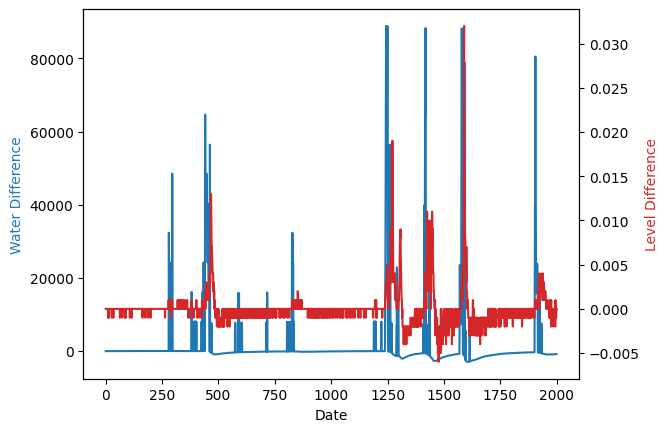

In [11]:
# Plot the water difference and the level derivative against the date with different axis scales
fig, ax1 = plt.subplots()
ax1.plot(merged['Water Difference'].iloc[0:2000])
ax1.set_xlabel('Date')
ax1.set_ylabel('Water Difference', color='tab:blue')
ax2 = ax1.twinx()
ax2.plot(merged['Level Difference'].iloc[0:2000], color='tab:red')
ax2.set_ylabel('Level Difference', color='tab:red')
plt.show()

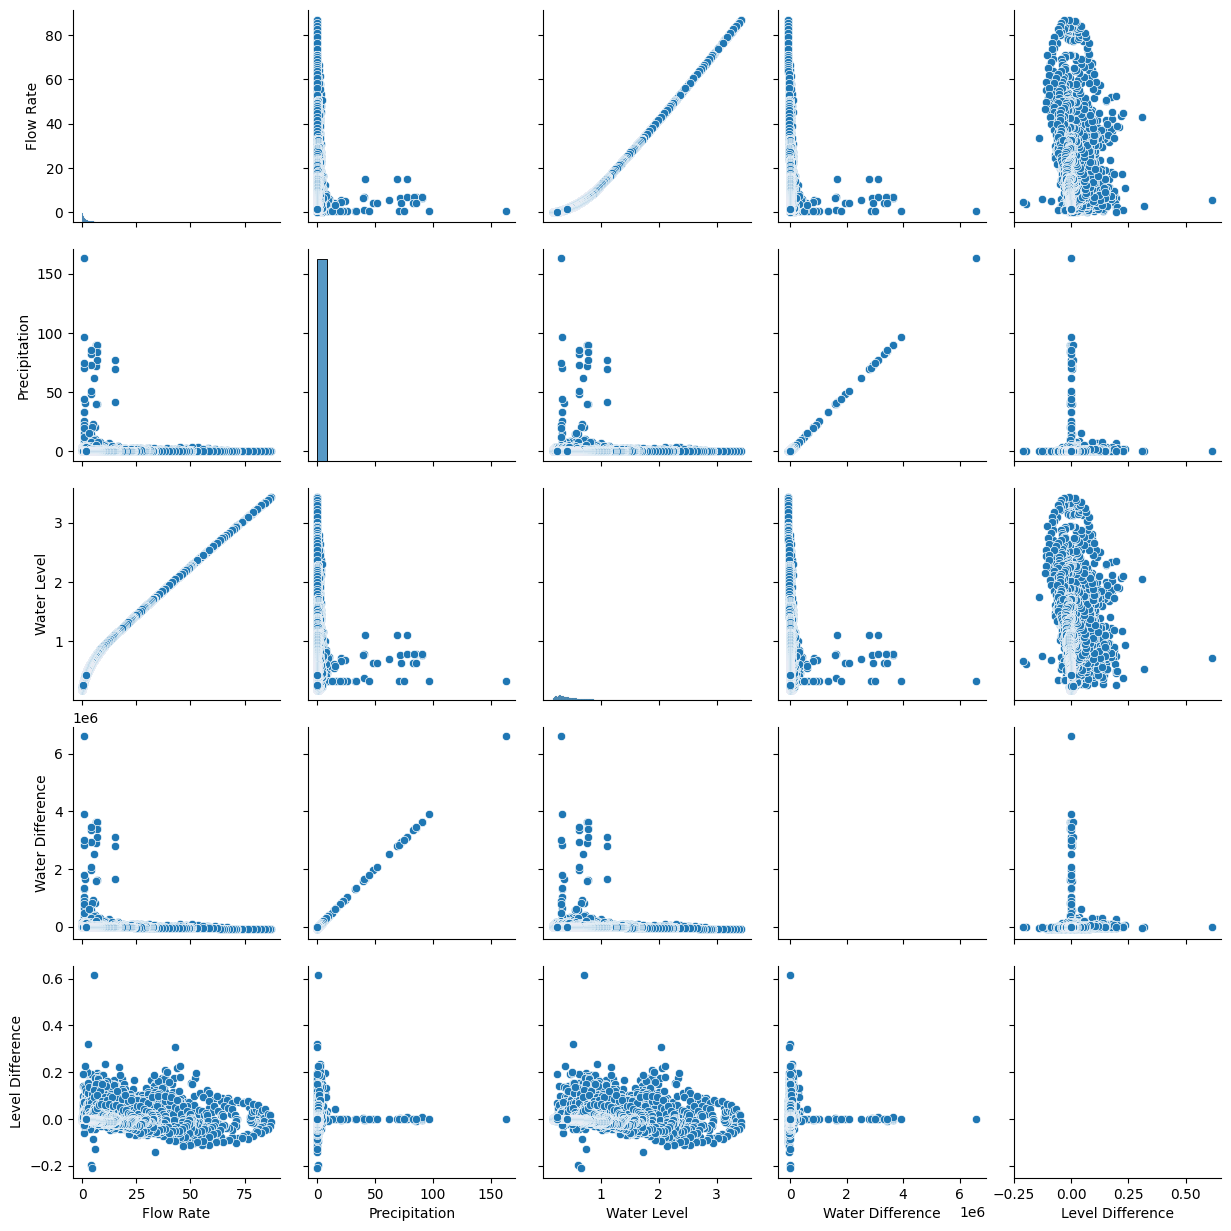

In [12]:
cols = ['Flow Rate', 'Precipitation', 'Water Level', 'Water Difference', 'Level Difference']
sns.pairplot(merged[cols], height=2.5)

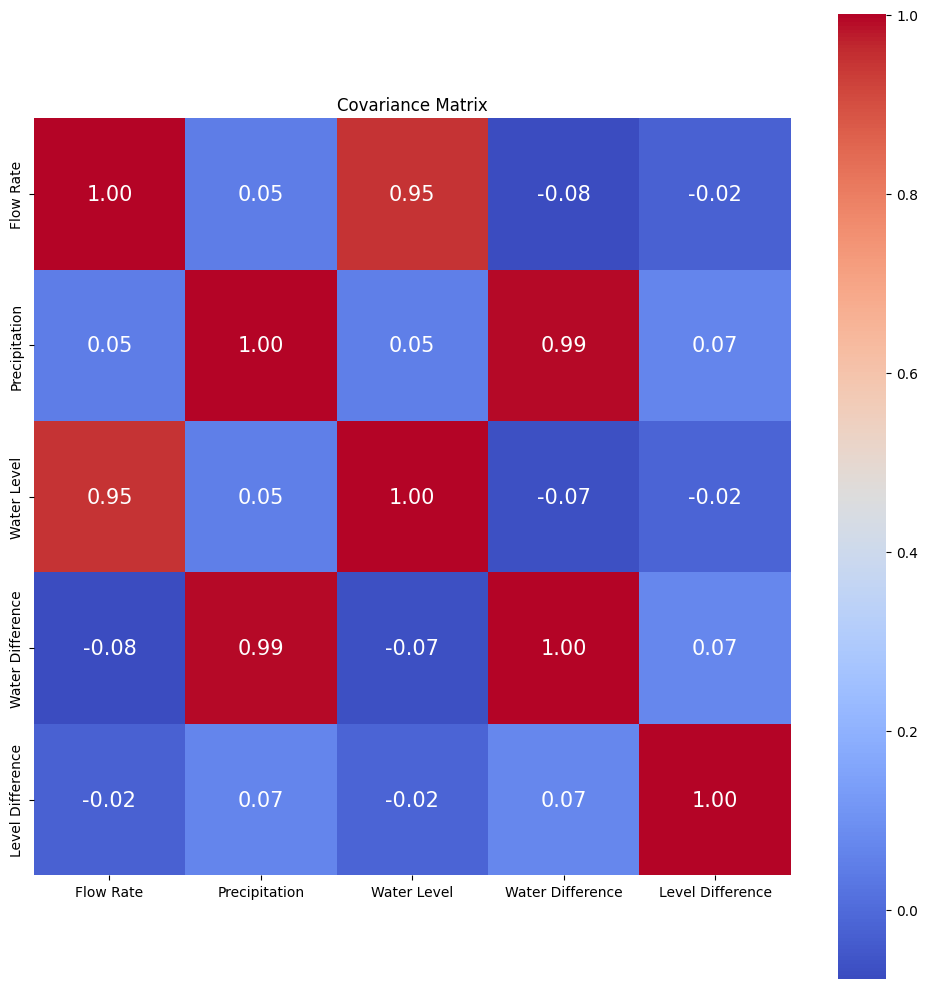

In [13]:
stdsc = StandardScaler()
X_std = stdsc.fit_transform(merged[cols].values)
cov_mat = np.cov(X_std.T)
plt.figure(figsize=(10, 10))
hm = sns.heatmap(cov_mat, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 15}, cmap='coolwarm', yticklabels=cols, xticklabels=cols)
plt.title('Covariance Matrix')
plt.tight_layout()
plt.show()

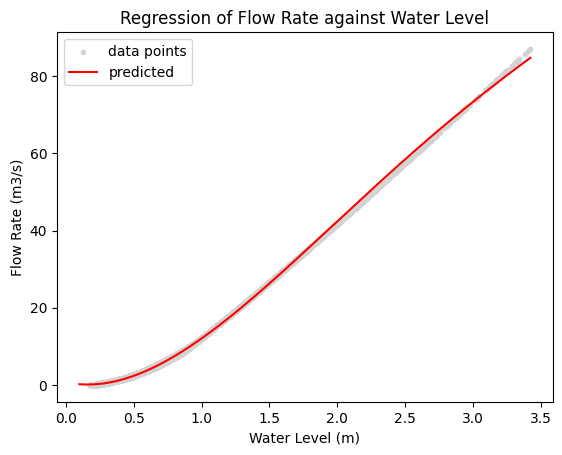

In [14]:
# Fit a polynomial curve to the data
X = merged['Water Level'].values.reshape(-1, 1)
y = merged['Flow Rate'].values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
quadratic = PolynomialFeatures(degree=4)
X_quad = quadratic.fit_transform(X)
X_quad_test = quadratic.fit_transform(X_test)
lr = LinearRegression()
lr.fit(X_quad, y)
y_quad_fit = lr.predict(X_quad)
y_quad_pred = lr.predict(X_quad_test)

# Plot the polynomial curve
plt.scatter(X, y, label='data points', color='lightgray', marker='.')

x = np.linspace(0.1, max(X), 1000)
y = lr.predict(quadratic.fit_transform(x.reshape(-1, 1)))
plt.plot(x, y, label='predicted', color='red')

plt.legend(loc='upper left')
plt.title('Regression of Flow Rate against Water Level')
plt.xlabel('Water Level (m)')
plt.ylabel('Flow Rate (m3/s)')
plt.show()